The objective of this notebook is to compare the methodologies used in linear regression: traditional statistical techniques versus machine learning optimization methods, such as gradient descent.
- First, I will demonstrate the statistical approach using a single variable.
- Next, I will show how to perform regression with two variables using matrix operations—a method that generalizes easily to more variables.
- Then, I will replicate the same procedure using a machine learning approach, specifically gradient descent.
- Finally, I will conclude by discussing the relevance of this methodological comparison for the field of data science and how it opens new possibilities for applying deep learning techniques.

In [1]:
from tqdm import tqdm
from typing import Tuple, List, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score 

In [2]:
# Data from: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data
# SalePrice - the property's sale price in dollars. This is the target variable that you're trying to predict.
# GrLivArea: Above-ground living area (in square feet)
# GarageArea: Garage size (in square feet)
df = pd.read_csv("./data/train.csv", usecols = ['Id', 'SalePrice', 'GrLivArea', 'GarageArea'])
df

,Id,GrLivArea,GarageArea,SalePrice
0,1,1710,548,208500
1,2,1262,460,181500
2,3,1786,608,223500
3,4,1717,642,140000
4,5,2198,836,250000
...,...,...,...,...
1455,1456,1647,460,175000
1456,1457,2073,500,210000
1457,1458,2340,252,266500
1458,1459,1078,240,142125


## Initial Checks
I am not focusing on exploratory data analysis (EDA) in this notebook. However, I will perform some basic data checks to identify any potential issues with the dataset.

Specifically, I want to verify:
- that all data types are correct (e.g., no unexpected characters in numeric variables),
- that there are no missing values,
- and that the variables exhibit some variance.

In [3]:
# Verify data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Id          1460 non-null   int64
 1   GrLivArea   1460 non-null   int64
 2   GarageArea  1460 non-null   int64
 3   SalePrice   1460 non-null   int64
dtypes: int64(4)
memory usage: 45.8 KB


In [4]:
# Missing values
df_missing = pd.DataFrame(df.isna().sum(), columns = ['missing_values'])
df_missing['percent'] = df_missing['missing_values'] / len(df)
df_missing.head(50)

,missing_values,percent
Id,0,0.0
GrLivArea,0,0.0
GarageArea,0,0.0
SalePrice,0,0.0


In [5]:
# Describe
df.describe()

,Id,GrLivArea,GarageArea,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,1515.463699,472.980137,180921.195890
std,421.610009,525.480383,213.804841,79442.502883
min,1.000000,334.000000,0.000000,34900.000000
25%,365.750000,1129.500000,334.500000,129975.000000
50%,730.500000,1464.000000,480.000000,163000.000000
75%,1095.250000,1776.750000,576.000000,214000.000000
max,1460.000000,5642.000000,1418.000000,755000.000000


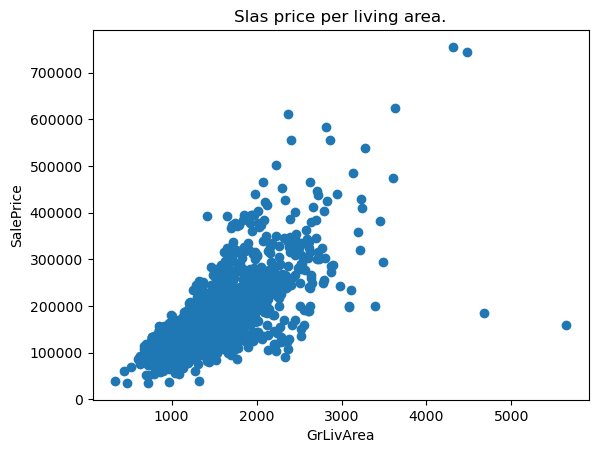

In [6]:
# Plot
# GrLivArea
X = df['GrLivArea']
y = df['SalePrice']
plt.scatter(X, y, label="Data")
plt.xlabel(f"GrLivArea")
plt.ylabel(f"SalePrice")
plt.title("Slas price per living area.")
plt.show()

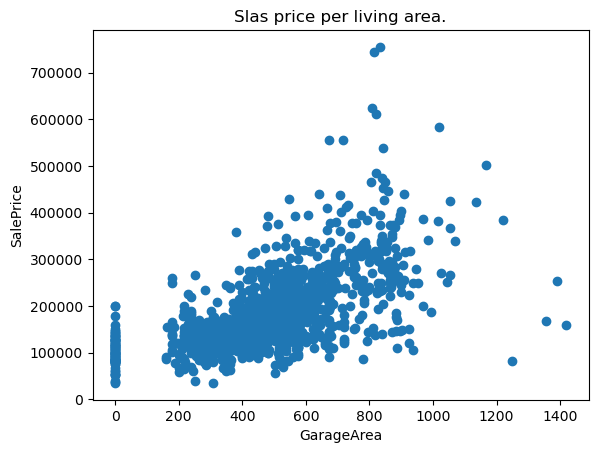

In [7]:
# Plot
# GarageArea
X = df['GarageArea']
y = df['SalePrice']
plt.scatter(X, y, label="Data")
plt.xlabel(f"GarageArea")
plt.ylabel(f"SalePrice")
plt.title("Slas price per living area.")
plt.show()

## 1. Statistical Approach (Single Variable)

We'll start by fitting a simple linear regression line using the closed-form solution of Ordinary Least Squares (OLS) with one independent variable.

### Mathematical Formulation

In simple linear regression, we aim to model the relationship between a dependent variable $y$ and an independent variable $x$ using the equation:

$$
y = \beta_0 + \beta_1 x + \varepsilon
$$

Where:  
- $\beta_0$ is the intercept  
- $\beta_1$ is the slope of the regression line  
- $\varepsilon$ is the error term (residual)

The OLS method finds the values of $\beta_0$ and $\beta_1$ that minimize the sum of squared residuals:

$$
\min \sum_{i=1}^{n} (y_i - \beta_0 - \beta_1 x_i)^2
$$

The optimal coefficients can be computed using the closed-form formulas:

$$
\beta_1 = \frac{\sum_{i=1}^{n} (x_i - \bar{x})(y_i - \bar{y})}{\sum_{i=1}^{n} (x_i - \bar{x})^2}
$$

$$
\beta_0 = \bar{y} - \beta_1 \bar{x}
$$

These equations give us the best-fitting line through the data by minimizing the total squared error.



In [8]:
# Calculate coefficients manually
X = df['GrLivArea']
y = df['SalePrice']

X_mean = np.mean(X)
y_mean = np.mean(y)

numerator = np.sum((X - X_mean) * (y - y_mean))
denominator = np.sum((X - X_mean)**2)
slope = numerator / denominator
intercept = y_mean - slope * X_mean

print(f"Intercept: {intercept:.2f}")
print(f"Coefficients: {slope:.2f}")


Intercept: 18569.03
Coefficients: 107.13


In [9]:
# Verify using scikit-learn
model = LinearRegression()
model.fit(df[['GrLivArea']], y)  
print(f"Intercept: {model.intercept_:.2f}")
print(f"Coefficients: {model.coef_}")
# ---

# Verify R2
y_pred = slope * X + intercept
r2_sklearn = r2_score(y, y_pred) 
print(f"R² (sklearn): {r2_sklearn:.4f}")

Intercept: 18569.03
Coefficients: [107.13035897]
R² (sklearn): 0.5021


## 2. Statistical Approach (Two Variables with Matrix Algebra)

Now we extend the linear regression approach to use **two or more features** by applying matrix algebra and the **Normal Equation**, which provides a closed-form solution for Ordinary Least Squares (OLS) in multiple linear regression.

### Mathematical Formulation

In multiple linear regression, we model the target variable $y$ as a linear combination of multiple input features:

$$
y = X\beta + \varepsilon
$$

Where:
- $X$ is the **design matrix** of shape $(n, p)$, where each row represents an observation and each column a feature (with the first column being all 1s for the intercept),
- $\beta$ is the **coefficient vector** of shape $(p, 1)$, containing the intercept and the weights for each feature,
- $\varepsilon$ is the **error vector** (residuals),
- $y$ is the **target vector** of shape $(n, 1)$.

The goal is to find the $\beta$ that minimizes the sum of squared errors. The solution is given by the **Normal Equation**:

$$
\hat{\beta} = (X^TX)^{-1}X^Ty
$$

This equation directly computes the optimal coefficients without the need for iterative optimization (like gradient descent).

**Note:**  
- This method assumes that $(X^TX)$ is invertible. If it is not (e.g., due to multicollinearity), numerical instability or singular matrix errors can occur.
- For most datasets with a moderate number of features and no perfect correlation, the Normal Equation is a very efficient solution.



In [10]:
# Create data with two variables
X1 = df['GrLivArea']
X2 = df['GarageArea']
y = df['SalePrice']

 # Add intercept term
X_mat = np.column_stack((np.ones_like(X1), X1, X2)) 

# Closed-form solution
beta_hat = np.linalg.inv(X_mat.T @ X_mat) @ X_mat.T @ y
print(f"Estimated coefficients: {beta_hat}")


Estimated coefficients: [-6915.38067356    80.67131781   138.65724537]


In [11]:
# Verify using scikit-learn
model = LinearRegression()
model.fit(df[['GrLivArea', 'GarageArea']], y)  
print(f"Intercept: {model.intercept_:.2f}")
print(f"Coefficients: {model.coef_}")
# ---

# Verify R2
y_pred = beta_hat[0] + beta_hat[1] * X1 + beta_hat[2] * X2
r2_sklearn = r2_score(y, y_pred) 
print(f"R² (sklearn): {r2_sklearn:.4f}")

Intercept: -6915.38
Coefficients: [ 80.67131781 138.65724537]
R² (sklearn): 0.6108


## 3. Linear Regression via Gradient Descent

In this section, we will compute the linear regression parameters using an **iterative optimization algorithm** called **Gradient Descent**, instead of solving the equations analytically.

### Mathematical Formulation

In linear regression, we model the target variable \( y \) as:

$$
y = X\beta + \varepsilon
$$

Where:
- $X$ is the design matrix (with a column of ones for the intercept),
- $\beta$ is the parameter vector (including intercept and feature weights),
- $\varepsilon$ is the error term.

Unlike the Normal Equation, which provides a closed-form solution, Gradient Descent finds the optimal $\beta$ by **iteratively updating the parameters** to minimize the **cost function** (also called the loss function).

### Cost Function (Mean Squared Error)

The objective is to minimize the **Mean Squared Error (MSE)** between predictions and true values:

$$
J(\beta) = \frac{1}{2m} \sum_{i=1}^{m} (h_\beta(x_i) - y_i)^2
$$

Where:
- $m$ is the number of training examples,
- $h_\beta(x_i) = x_i^T \beta $ is the prediction for input $x_i$,
- $y_i $ is the true target value for example $i$.

We include the factor $\frac{1}{2}$ for convenience when taking derivatives.

### Gradient Descent Update Rule

To minimize the cost, we repeatedly update the parameters $\beta$ using the gradient of the cost function:

$$
\beta := \beta - \alpha \cdot \nabla_\beta J(\beta)
$$

Where:
- $\alpha$ is the **learning rate**, a small positive scalar that controls the step size,
- $\nabla_\beta J(\beta) $ is the **gradient** of the cost function with respect to $\beta$.

The gradient (vector of partial derivatives) for the MSE cost function is:

$$
\nabla_\beta J(\beta) = \frac{1}{m} X^T(X\beta - y)
$$

So the update rule becomes:

$$
\beta := \beta - \alpha \cdot \frac{1}{m} X^T(X\beta - y)
$$

This process is repeated for a number of **epochs** (iterations) until the cost converges (i.e., changes very little between steps).

### The Importance of Choosing a Proper Learning Rate

Choosing a good learning rate $\alpha$ is critical for the success of gradient descent:

- If $\alpha$ is **too small**, the algorithm will converge **very slowly**, taking many iterations to reach a good solution.
- If $\alpha$ is **too large**, the updates can overshoot the minimum, causing the cost to **diverge** or **oscillate wildly**, potentially leading to numerical instability.

In practice, choosing a learning rate requires experimentation, and it's common to visualize the cost over time to verify convergence.


### Summary

Gradient Descent is a powerful optimization algorithm that:
- Scales well to large datasets,
- Allows for customizations (like regularization),
- Forms the foundation of many advanced machine learning algorithms, including deep learning.

However, it requires:
- Choosing a proper learning rate,
- Feature scaling for faster convergence,
- Monitoring to avoid local minima or divergence.

In the next step, we’ll implement this logic in code and visualize the optimization process.


In [12]:
class LinearRegressionGD:
    """
    Batch‑gradient‑descent linear regression.

    * Features and target are scaled internally for stability.
    * `predict()` automatically reverses the scaling.
    """

    def __init__(self, lr: float = 1e-5, epochs: int = 10_000,
                 tol: float = 1e-8, verbose: bool = True):
        # hyper‑parameters
        self.lr = lr          # learning rate
        self.epochs = epochs  # max passes over the data
        self.tol = tol        # stop if cost improves less than this
        self.verbose = verbose

        # attributes set during fit
        self.theta_ = None            # coefficients
        self.cost_history_ = []       # cost at each epoch

    # ─────────────────────────────────────────────────────────────
    def fit(self, X: np.ndarray, y: np.ndarray):
        """Train the model on raw (unscaled) X and y."""
        # 1) save means/stds so we can unscale later
        self.x_mu_, self.x_sig_ = X.mean(0), X.std(0)
        self.y_mu_, self.y_sig_ = y.mean(), y.std()

        # 2) Normalize the data
        # Scaling the features and target to have zero mean and unit variance
        # helps gradient descent converge faster and more reliably.
        # Without normalization, features with larger magnitudes dominate the updates,
        # which can lead to slow convergence or even divergence.
        Xs = (X - self.x_mu_) / self.x_sig_
        ys = (y - self.y_mu_) / self.y_sig_

        # 3) add bias term (column of 1s)
        Xb = np.c_[np.ones(Xs.shape[0]), Xs]

        # 4) initialise θ with zeros
        m, n = Xb.shape
        self.theta_ = np.zeros(n)

        # 5) gradient‑descent loop
        for epoch in tqdm(range(self.epochs), desc="GD"):
            preds   = Xb @ self.theta_          # current predictions
            errors  = preds - ys                # residuals
            grad    = (1 / m) * (Xb.T @ errors) # gradient of the cost
            self.theta_ -= self.lr * grad       # parameter update

            # track cost (MSE/2 on scaled data)
            cost = (errors @ errors) / (2 * m)
            self.cost_history_.append(cost)

            # early‑stop if cost is NaN/Inf or barely improving
            if (not np.isfinite(cost)) or (
                epoch > 0 and abs(self.cost_history_[-2] - cost) < self.tol):
                if self.verbose:
                    print(f"Stopped at epoch {epoch}")
                break
        return self

    # ─────────────────────────────────────────────────────────────
    def predict(self, X: np.ndarray) -> np.ndarray:
        """Return predictions in the **original** target scale."""
        if self.theta_ is None:
            raise RuntimeError("Call `fit` first.")

        # scale features, add bias
        Xs = (X - self.x_mu_) / self.x_sig_
        # Add a column of 1s as the intercept term
        Xb = np.c_[np.ones(Xs.shape[0]), Xs]  # np.c_ is a convenient shortcut in NumPy used for column-wise concatenation of arrays. It works like np.concatenate(..., axis=1) but with a more readable syntax.

        # predicted target, then un‑scale back to dollars
        ys_scaled = Xb @ self.theta_
        return ys_scaled * self.y_sig_ + self.y_mu_


# ─────────────────────────────────────────────────────────────
# Example use
# ─────────────────────────────────────────────────────────────
X = df[["GrLivArea", "GarageArea"]].values
y = df["SalePrice"].values

model = LinearRegressionGD(lr=1e-3, epochs=20_000, tol=1e-15)
model.fit(X, y)

print("θ (intercept, GrLivArea, GarageArea):", model.theta_)

# R² on training data
y_pred = model.predict(X)
print(f"R² (sklearn): {r2_score(y, y_pred):.4f}")


GD: 100%|█████████████████████████████████████████████████████████████████████| 20000/20000 [00:00<00:00, 79518.15it/s]

θ (intercept, GrLivArea, GarageArea): [2.12476460e-16 5.33606549e-01 3.73172351e-01]
R² (sklearn): 0.6108


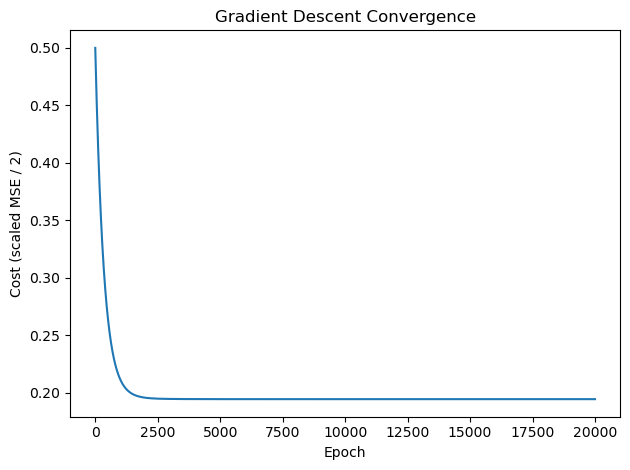

In [13]:
# -------------------------------------------------------------------
# Plot the cost (error) versus epoch
# -------------------------------------------------------------------
plt.figure()
plt.plot(model.cost_history_)
plt.xlabel("Epoch")
plt.ylabel("Cost (scaled MSE / 2)")
plt.title("Gradient Descent Convergence")
plt.tight_layout()
plt.show()

## 4. Conclusion: The Importance of Gradient Descent

While traditional statistical methods like Ordinary Least Squares (OLS) provide efficient closed-form solutions for linear regression, they become **impractical** or **infeasible** for more complex models and large datasets.

This is where **Gradient Descent (GD)** plays a crucial role.

### Why Gradient Descent Matters

Gradient Descent is a **general-purpose optimization algorithm** that allows us to minimize a wide range of cost functions, even when:
- The model has **many parameters**,
- The cost function is **non-convex** or **nonlinear**,
- A closed-form solution is either **intractable** or **does not exist**.

It offers flexibility and scalability, making it suitable for training models far more complex than simple linear regression.

### Enabling Deep Learning

Modern **deep learning**—involving neural networks with **millions of parameters** and **nonlinear activation functions**—would not be possible without gradient-based optimization.

Since there is no closed-form solution for training deep neural networks, algorithms like **Stochastic Gradient Descent (SGD)** and its variants (e.g., Adam, RMSProp) are used to iteratively update parameters and minimize the loss function.

In essence, **gradient descent is the backbone of deep learning**. Without it, training models like convolutional neural networks (CNNs), recurrent neural networks (RNNs), and transformers would simply not be feasible.

### Summary

- **Closed-form solutions** are elegant but limited in scope.
- **Gradient descent** generalizes optimization to a wide range of models.
- It has **enabled the modern AI revolution**, making it possible to train deep learning models that solve complex real-world problems—from image recognition to natural language understanding.

By understanding gradient descent in the context of linear regression, we gain insight into the **foundational technique** powering today's most advanced machine learning systems.



